# **Import Library**

In [ ]:
# --- Library untuk Manipulasi dan Analisis Data ---
import os
import re
import numpy as np
import pandas as pd
import zipfile

# --- Library untuk Visualisasi ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Library untuk Pemrosesan Teks ---
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec

# Unduh resource NLTK yang diperlukan
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# --- Library untuk Machine Learning ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, cohen_kappa_score, classification_report

# --- Library untuk Deep Learning ---
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Layer, Embedding, Input, LSTM, Dense, Dropout, BatchNormalization, Bidirectional,
    Lambda, TextVectorization, SpatialDropout1D, GlobalMaxPooling1D
)
from tensorflow.keras import saving
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Cek versi library
print("TensorFlow:", tf.__version__)

TensorFlow: 2.17.1


## Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path ke file zip di Google Drive
zip_path = '/content/drive/MyDrive/learning-agency-lab-automated-essay-scoring-2.zip'
extract_path = '/content/dataset'

# Mengekstrak file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Memastikan bahwa file telah diekstrak
extracted_files = os.listdir(extract_path)
print("Files in extracted folder:", extracted_files)

# Cek apakah file yang dibutuhkan ada sebelum memuatnya
train_file = os.path.join(extract_path, 'train.csv')
test_file = os.path.join(extract_path, 'test.csv')
sample_submission_file = os.path.join(extract_path, 'sample_submission.csv')

if all(os.path.exists(file) for file in [train_file, test_file, sample_submission_file]):
    # Membaca dataset yang diekstraksi
    train = pd.read_csv(train_file)
    test = pd.read_csv(test_file)
    sample_submission = pd.read_csv(sample_submission_file)

Files in extracted folder: ['train.csv', 'test.csv', 'sample_submission.csv']


# **Exploratory Data Analysis**

## Informasi Dataset

{test/train}.csv
* essay_id: Pengenal unik untuk setiap esai.
* full_text: Teks esai.
* score: Skor esai dengan rentang 1-6.

sample_submission.csv : Sampel valid yang dimasukkan untuk prediksi.  

In [ ]:
print('train data shape:', train.shape )
train.head()

train data shape: (17307, 3)


,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


In [ ]:
train.describe()

,score
count,17307.000000
mean,2.948402
std,1.044899
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,6.000000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17307 entries, 0 to 17306
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   essay_id   17307 non-null  object
 1   full_text  17307 non-null  object
 2   score      17307 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 405.8+ KB


In [ ]:
train.isnull().sum()

,0
essay_id,0
full_text,0
score,0


In [ ]:
print('test data shape:', test.shape )
test.head()

test data shape: (3, 2)


,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [ ]:
test.isnull().sum()

,0
essay_id,0
full_text,0


In [ ]:
sample_submission.head()

,essay_id,score
0,000d118,3
1,000fe60,3
2,001ab80,4


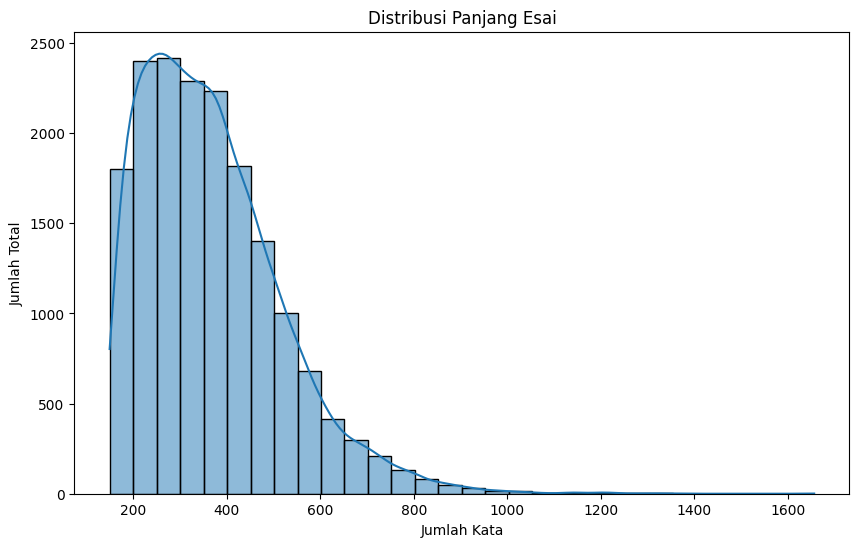

In [ ]:
# Menghitung panjang esai berdasarkan jumlah kata yang dipisahkan oleh spasi dalam setiap teks.
essay_lengths = train['full_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(essay_lengths, bins=30, kde=True)
plt.title('Distribusi Panjang Esai')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Total')
plt.show()

In [ ]:
# Hitung jumlah kata pada setiap esai
essay_lengths = train['full_text'].apply(lambda x: len(x.split()))

print(f"Minimum Panjang Esai: {essay_lengths.min()} kata")
print(f"Maximum Panjang Esai: {essay_lengths.max()} kata")
print(f"Rata-rata Panjang Esai: {essay_lengths.mean():.2f} kata")
print(f"Median Panjang Esai: {essay_lengths.median()} kata")
print(f"25th Persentil: {essay_lengths.quantile(0.25)} kata")
print(f"50th Persentil (Median): {essay_lengths.quantile(0.50)} kata")
print(f"75th Persentil: {essay_lengths.quantile(0.75)} kata")

Minimum Panjang Esai: 150 kata
Maximum Panjang Esai: 1656 kata
Rata-rata Panjang Esai: 368.35 kata
Median Panjang Esai: 345.0 kata
25th Persentil: 253.0 kata
50th Persentil (Median): 345.0 kata
75th Persentil: 452.0 kata


<ipython-input-14-17e5cb8ffaec>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='score', data=train, palette='viridis')


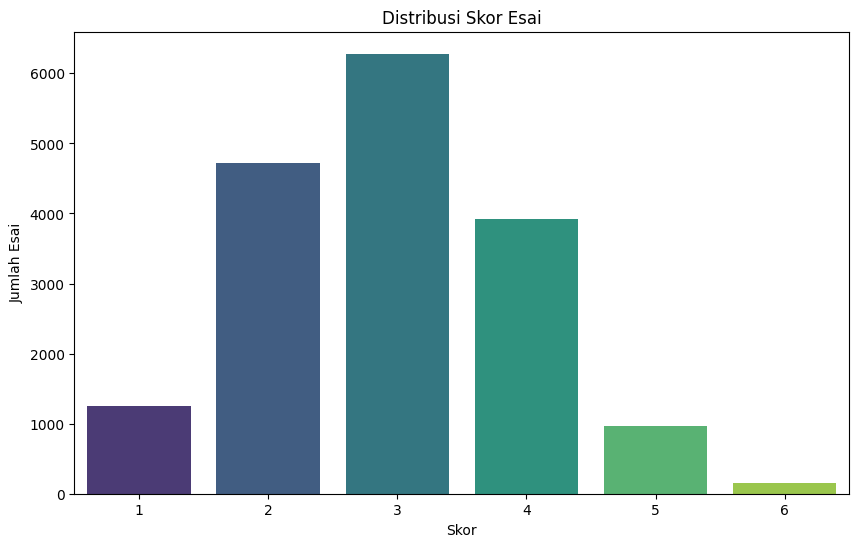

In [ ]:
# Distribusi skor esai
plt.figure(figsize=(10, 6))
sns.countplot(x='score', data=train, palette='viridis')
plt.title('Distribusi Skor Esai')
plt.xlabel('Skor')
plt.ylabel('Jumlah Esai')
plt.show()

In [ ]:
train['score'].value_counts()

,count
score,
3,6280
2,4723
4,3926
1,1252
5,970
6,156


In [ ]:
train['full_text'].head()

,full_text
0,Many people have car where they live. The thin...
1,I am a scientist at NASA that is discussing th...
2,People always wish they had the same technolog...
3,"We all heard about Venus, the planet without a..."
4,"Dear, State Senator\n\nThis is a letter to arg..."


# **Preprocessing Data**

In [ ]:
# Membersihkan teks
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

In [ ]:
# Implementasi pembersihan teks
train['clean_text'] = train['full_text'].apply(clean_text)
test['clean_text'] = test['full_text'].apply(clean_text)

In [ ]:
train['clean_text'].value_counts()

,count
clean_text,
venus is worthy place to study but dangerous the reaosn in doing theis is because of the challenge there is trying to study something with out going for yourself that is pretty hard to do one you have the biuld something that will either help your or something that can with so the temputure of venus two the distance of getting there and back gotta have something to hold that uch fuel to go there and come home if a human is going you need to have a food stock for them to last of the planet just like when they sent a robot to the planet it had to out a material tthat can withstand the planet itself but that only lasted two weeks now they are try to go for longer the two weeks in conclusion i know that tcan do it its just going to take some time for it to happen,1
many people have car where they live the thing they dont know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in vaubangermany they dont have that proble because 70 percent of vaubans families do not own carsand 57 percent sold a car to move there street parkig driveways and home garages are forbidden on the outskirts of freiburd that near the french and swiss borders you probaly wont see a car in vaubans streets because they are completely car free but if some that lives in vauban that owns a car ownership is allowedbut there are only two places that you can park a large garages at the edge of the developmentwhere a car owner buys a space but it not cheap to buy one they sell the space for you car for 40000 along with a home the vauban people completed this in 2006 they said that this an example of a growing trend in europethe untile states and some where else are suburban life from auto use this is called smart planning the current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in europe and up to 50 percent in some car intensive in the united states i honeslty think that good idea that they did that is vaudan because that makes cities denser and better for walking and in vauban there are 5500 residents within a rectangular square mile in the artical david gold berg said that all of our development since world war 2 has been centered on the carsand that will have to change and i think that was very true what david gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in vauban so people can see how we really dont need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car it good that they are doing that if you thik about your help the earth in way and thats a very good thing to in the united states the environmental protection agency is promoting what is called car reducedcommuntuntiesand the legislators are starting to actif cautiously maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year in previous bill80 percent of appropriations have by law gone to highways and only 20 percent to other transports there many good reason why they should do this,1
i am a scientist at nasa that is discussing the face on mars i will be explaining how the face is a land form by sharing my information about this isue i will tell you just that first off how could it be a martions drawing there is no plant life on mars as of rite now that we know of which means so far as we know it is not possible for any type of life that explains how it could not be made by martians also why and how would a martion build a face so big it just does not make any since that a martian did this next why it is a landform there are many landforms that are

In [ ]:
# Tokenisasi teks menjadi kata-kata
train_tokens = [word_tokenize(text) for text in train['clean_text']]
test_tokens = [word_tokenize(text) for text in test['clean_text']]

In [ ]:
# Melatih model Word2Vec
model_w2v = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# Menyimpan model untuk penggunaan di masa mendatang
model_w2v.save("word2vec_model")

In [ ]:
# Fungsi untuk mendapatkan vektor rata-rata kata
def get_average_word2vec(tokens_list, model, vector_size):
    vec = np.zeros(vector_size)
    valid_words = 0
    for word in tokens_list:
        if word in model.wv:
            vec += model.wv[word]
            valid_words += 1
    if valid_words > 0:
        vec /= valid_words
    return vec

In [ ]:
# Menyusun fitur teks dengan vektor rata-rata Word2Vec
X_train_w2v = np.array([get_average_word2vec(tokens, model_w2v, 100) for tokens in train_tokens])
X_test_w2v = np.array([get_average_word2vec(tokens, model_w2v, 100) for tokens in test_tokens])

In [ ]:
# Target variable: the score (1-6)
y_train = train['score'].values



# **Modelling Data**

In [ ]:
# Membagi data X_train_w2v dan y_train menjadi train dan validation set dengan stratifikasi berdasarkan 'score'
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_w2v, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [ ]:
# Mengubah input menjadi 3D untuk LSTM: (batch_size, 1, features)
X_train_final_lstm = np.expand_dims(X_train_final, axis=1)  # Menambahkan dimensi waktu (timesteps)
X_val_lstm = np.expand_dims(X_val, axis=1)

In [ ]:
# Mendefinisikan kelas custom layer untuk melakukan reskalasi output
@saving.register_keras_serializable()  # Dekorator untuk memastikan layer ini dapat diserialisasi oleh Keras
class RescaleOutput(Layer):
    def __init__(self, **kwargs):
        """
        Konstruktor untuk lapisan RescaleOutput.
        Memanggil konstruktor parent class (Layer).
        """
        super(RescaleOutput, self).__init__(**kwargs)

    def call(self, inputs):
        """
        Fungsi yang menentukan bagaimana input diproses di lapisan ini.
        Fungsi ini akan mengubah skala nilai output dari [0, 1] ke [1, 6].
        Formula: output = input * 5 + 1
        """
        return inputs * 5 + 1

#BUILD MODEL

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 2.0759 - mae: 1.1096 - val_loss: 0.9965 - val_mae: 0.7956 - learning_rate: 0.0010
Epoch 2/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.9838 - mae: 0.7968 - val_loss: 0.7908 - val_mae: 0.7192 - learning_rate: 0.0010
Epoch 3/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.9544 - mae: 0.7830 - val_loss: 0.7666 - val_mae: 0.7066 - learning_rate: 0.0010
Epoch 4/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.9131 - mae: 0.7628 - val_loss: 0.7512 - val_mae: 0.6987 - learning_rate: 0.0010
Epoch 5/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.8813 - mae: 0.7542 - val_loss: 0.7325 - val_mae: 0.6876 - learning_rate: 0.0010
Epoch 6/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.8787 - mae: 0.7475 - val_loss: 0.7228 - val_mae: 0.6848 - learning_rate: 0.0010
Epoch 7/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.8447 - mae: 0.7318 - val_loss: 0.7299 - val_mae: 0.6867 - learning_rate: 0.0010
Epoch 

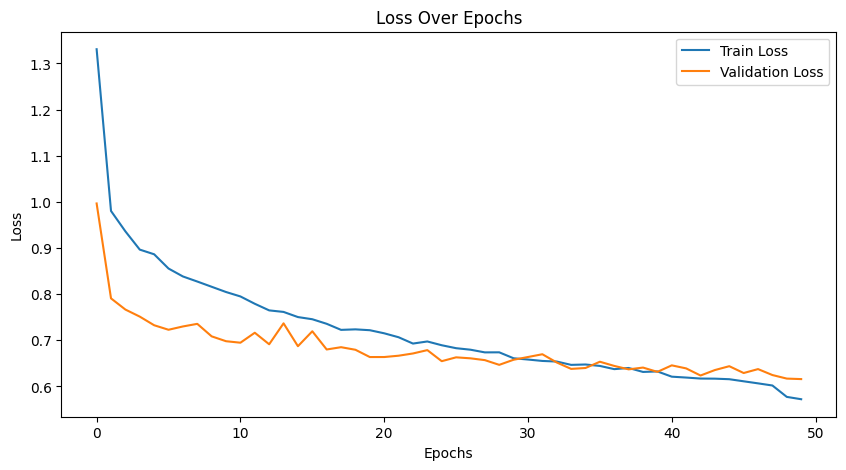

In [ ]:
# Build LSTM Model
model = Sequential([
    LSTM(128, input_shape=(1, 100), return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Train the model
history = model.fit(
    X_train_final_lstm, y_train_final,
    validation_data=(X_val_lstm, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

# Evaluate the model
evaluation = model.evaluate(X_val_lstm, y_val)
print("Model Evaluation (Loss, MAE):", evaluation)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


Epoch 1/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan - learning_rate: 0.0010
Epoch 2/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan - learning_rate: 0.0010
Epoch 3/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan - learning_rate: 0.0010
Epoch 4/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan - learning_rate: 0.0010
Epoch 5/50
427/433 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: nan
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
433/433 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan - learning_rate: 0.0010
Epoch 6/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0000e+00 - 

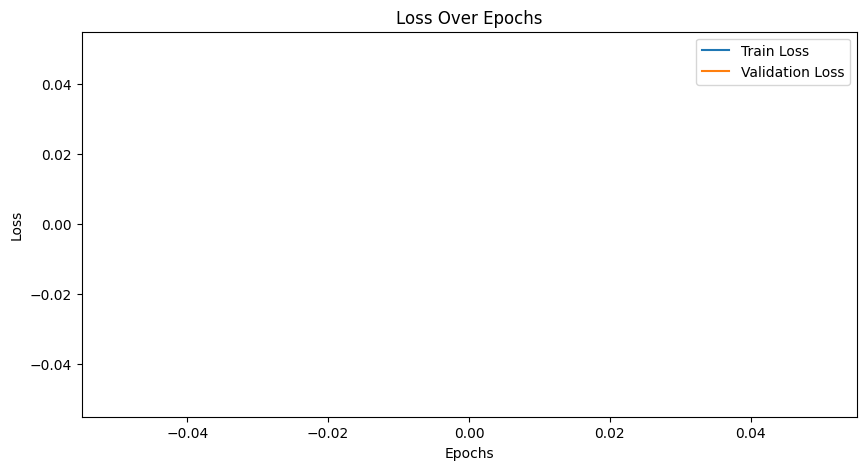

In [ ]:
# Build LSTM Model
model = Sequential([
    LSTM(128, input_shape=(1, 100), return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Train the model
history = model.fit(
    X_train_final_lstm, y_train_final,
    validation_data=(X_val_lstm, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

# Evaluate the model
evaluation = model.evaluate(X_val_lstm, y_val)
print("Model Evaluation (Loss, MAE):", evaluation)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 1, 100)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 1, 256)         │        234,496 │ input_layer_4[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 1, 256)         │              0 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 256)         │              0 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 1, 256)         │         65,792 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1, 1)           │            257 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 1, 256)         │              0 │ reshape[0][0],         │
│                           │                        │                │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 256)            │              0 │ multiply[0][0]         │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 64)             │         16,448 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 64)             │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64)             │            256 │ dropout_6[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)              │             65 │ batch_normalization[0… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 317,314 (1.21 MB)

 Trainable params: 317,186 (1.21 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


433/433 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 5.2120 - mae: 1.8711 - val_loss: 0.8953 - val_mae: 0.7590 - learning_rate: 0.0010
Epoch 2/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9087 - mae: 0.7639 - val_loss: 0.8075 - val_mae: 0.7263 - learning_rate: 0.0010
Epoch 3/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.8763 - mae: 0.7511 - val_loss: 0.7823 - val_mae: 0.7127 - learning_rate: 0.0010
Epoch 4/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.8305 - mae: 0.7313 - val_loss: 0.7390 - val_mae: 0.6941 - learning_rate: 0.0010
Epoch 5/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.8034 - mae: 0.7198 - val_loss: 0.7417 - val_mae: 0.6950 - learning_rate: 0.0010
Epoch 6/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.7841 - mae: 0.7119 - val_loss: 0.7505 - val_mae: 0.6957 - learning_rate: 0.0010
Epoch 7/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.7812 - mae: 0.7123 - val_loss: 0.7459 - val_mae: 0.6922 - learning_rate: 0.0010
Epoch 8/50
433

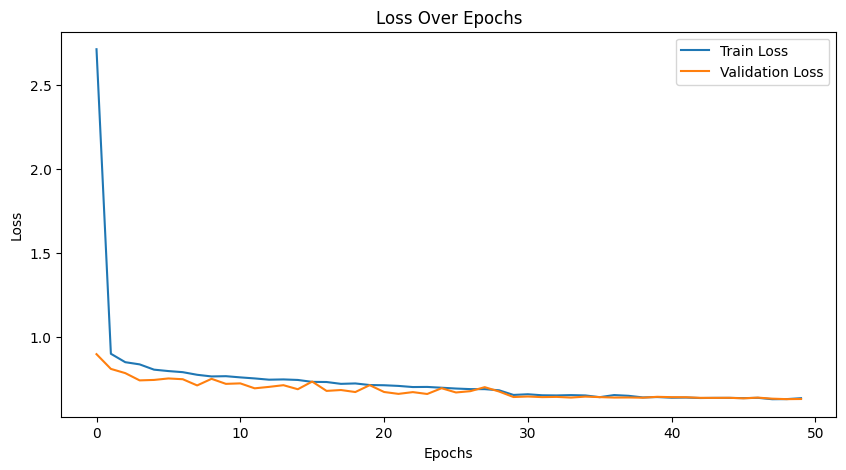

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Multiply,
    GlobalAveragePooling1D, Permute, Reshape, Softmax
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Attention Layer
def attention_layer(inputs):
    # Dense layer to calculate attention scores
    attention_scores = Dense(inputs.shape[-1], activation='tanh')(inputs)
    attention_scores = Dense(1, activation='softmax')(attention_scores)
    # Multiply attention scores with inputs
    context_vector = Multiply()([inputs, attention_scores])
    # Pooling to aggregate context
    context_vector = GlobalAveragePooling1D()(context_vector)
    return context_vector

# Input layer
input_layer = Input(shape=(1, 100))  # Sesuai preprocessing Word2Vec Anda

# Bidirectional LSTM with return_sequences=True
bi_lstm = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
bi_lstm = Dropout(0.3)(bi_lstm)

# Reshape to ensure 3D for Attention Layer
reshaped_lstm = Reshape((bi_lstm.shape[1], bi_lstm.shape[-1]))(bi_lstm)

# Attention Mechanism
context_vector = attention_layer(reshaped_lstm)

# Fully connected layers
dense = Dense(64, activation='relu')(context_vector)
dense = Dropout(0.3)(dense)
dense = BatchNormalization()(dense)

# Output layer
output_layer = Dense(1, activation='linear')(dense)  # Tugas regresi

# Compile Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model Summary
model.summary()

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Train the Model
history = model.fit(
    X_train_final_lstm, y_train_final,  # Preprocessed input dari file Anda
    validation_data=(X_val_lstm, y_val),  # Validation data
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

# Evaluate the Model
evaluation = model.evaluate(X_val_lstm, y_val)
print("Model Evaluation (Loss, MAE):", evaluation)

# Visualizing Training History
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Step 1: Perbaiki Dimensi Input dan Target
# Remove extra dimensions if present
if len(X_train_final_lstm.shape) == 4:
    X_train_fixed = np.squeeze(X_train_final_lstm)  # Remove redundant dimensions
    X_val_fixed = np.squeeze(X_val_lstm)
elif len(X_train_final_lstm.shape) == 2:
    X_train_fixed = np.expand_dims(X_train_final_lstm, axis=1)  # Add missing timesteps
    X_val_fixed = np.expand_dims(X_val_lstm, axis=1)
else:
    X_train_fixed = X_train_final_lstm
    X_val_fixed = X_val_lstm

# Ensure target is 1D
y_train_fixed = np.array(y_train_final).flatten()
y_val_fixed = np.array(y_val).flatten()

# Validate shapes
print("Corrected X_train shape:", X_train_fixed.shape)  # (batch_size, timesteps, features)
print("Corrected y_train shape:", y_train_fixed.shape)  # (batch_size,)

# Step 2: Define the Model
model = Sequential([
    # Embedding Layer with Pre-trained Word2Vec
    Embedding(
        input_dim=model_w2v.wv.vectors.shape[0],  # Vocabulary size
        output_dim=model_w2v.wv.vectors.shape[1],  # Embedding dimension
        input_length=X_train_fixed.shape[1],  # Input sequence length
        weights=[model_w2v.wv.vectors],  # Pre-trained embedding weights
        trainable=False  # Keep embeddings fixed
    ),
    LSTM(128, return_sequences=False),  # LSTM layer for sequential learning
    Dropout(0.3),  # Dropout for regularization
    Dense(64, activation='relu'),  # Fully connected dense layer
    Dropout(0.3),
    BatchNormalization(),  # Batch normalization for stability
    Dense(1, activation='linear')  # Output layer for regression
])

# Step 3: Compile the Model
model.compile(
    optimizer='adam',
    loss='mse',  # Loss function for regression
    metrics=['mae']  # Mean Absolute Error for evaluation
)

# Model Summary
model.summary()

# Step 4: Callbacks for Optimization
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Step 5: Train the Model
history = model.fit(
    X_train_fixed, y_train_fixed,  # Preprocessed training data
    validation_data=(X_val_fixed, y_val_fixed),  # Validation data
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

# Step 6: Evaluate the Model
evaluation = model.evaluate(X_val_fixed, y_val_fixed)
print("Model Evaluation (Loss, MAE):", evaluation)

# Step 7: Visualize Training History
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │       7,667,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,667,100 (29.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,667,100 (29.25 MB)

Epoch 1/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 4.5345 - mae: 1.6641 - val_loss: 2.1430 - val_mae: 1.1587 - learning_rate: 0.0010
Epoch 2/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 1.5304 - mae: 0.9978 - val_loss: 1.8142 - val_mae: 1.0624 - learning_rate: 0.0010
Epoch 3/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 1.3480 - mae: 0.9331 - val_loss: 1.5239 - val_mae: 1.0030 - learning_rate: 0.0010
Epoch 4/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 1.2879 - mae: 0.9063 - val_loss: 1.1973 - val_mae: 0.9001 - learning_rate: 0.0010
Epoch 5/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 1.2340 - mae: 0.8930 - val_loss: 1.1574 - val_mae: 0.8791 - learning_rate: 0.0010
Epoch 6/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 1.2222 - mae: 0.8831 - val_loss: 1.1022 - val_mae: 0.8326 - learning_rate: 0.0010
Epoch 7/50
433/433 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 1.1826 - mae: 0.8682 - val_loss: 1.0978 - val_mae: 0.8251 - learning_rate: 0.0

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt

# Ensure input dimensions are correct
X_train_fixed = np.array(X_train_final_lstm).reshape(-1, X_train_final_lstm.shape[1])
X_val_fixed = np.array(X_val_lstm).reshape(-1, X_val_lstm.shape[1])

# Ensure data type is float32
X_train_fixed = X_train_fixed.astype('float32')
X_val_fixed = X_val_fixed.astype('float32')
y_train_fixed = np.array(y_train_final).astype('float32')
y_val_fixed = np.array(y_val).astype('float32')

# Define the model
model = Sequential([
    # Embedding Layer with Pre-trained Word2Vec
    Embedding(
        input_dim=model_w2v.wv.vectors.shape[0],  # Vocabulary size
        output_dim=model_w2v.wv.vectors.shape[1],  # Embedding dimension
        input_length=X_train_fixed.shape[1],  # Input sequence length
        weights=[model_w2v.wv.vectors],  # Pre-trained embedding weights
        trainable=False  # Keep embeddings fixed
    ),
    LSTM(128, return_sequences=False),  # LSTM layer for sequential learning
    Dropout(0.3),  # Dropout for regularization
    Dense(64, activation='relu'),  # Fully connected dense layer
    Dropout(0.3),
    BatchNormalization(),  # Batch normalization for stability
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',  # Loss function for regression
    metrics=['mae']  # Mean Absolute Error for evaluation
)

# Model Summary
model.summary()

# Callbacks for optimization
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Train the model
history = model.fit(
    X_train_fixed, y_train_fixed,  # Preprocessed training data
    validation_data=(X_val_fixed, y_val_fixed),  # Validation data
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

# Evaluate the model
evaluation = model.evaluate(X_val_fixed, y_val_fixed)
print("Model Evaluation (Loss, MAE):", evaluation)

# Visualize Training History
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │       7,667,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,667,100 (29.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,667,100 (29.25 MB)

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 1384500
'y' sizes: 13845


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the model
model = Sequential([
    # Embedding Layer with Pre-trained Word2Vec
    Embedding(
        input_dim=model_w2v.wv.vectors.shape[0],  # Vocabulary size
        output_dim=model_w2v.wv.vectors.shape[1],  # Embedding dimension
        input_length=X_train_final_lstm.shape[1],  # Input sequence length
        weights=[model_w2v.wv.vectors],  # Pre-trained embedding weights
        trainable=False  # Keep embeddings fixed
    ),
    LSTM(128, return_sequences=False),  # LSTM layer for sequential learning
    Dropout(0.3),  # Dropout for regularization
    Dense(64, activation='relu'),  # Fully connected dense layer
    Dropout(0.3),
    BatchNormalization(),  # Batch normalization for stability
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',  # Loss function for regression
    metrics=['mae']  # Mean Absolute Error for evaluation
)

# Model Summary
model.summary()

# Callbacks for optimization
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Train the model
history = model.fit(
    X_train_final_lstm, y_train_final,  # Preprocessed training data
    validation_data=(X_val_lstm, y_val),  # Validation data
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

# Evaluate the model
evaluation = model.evaluate(X_val_lstm, y_val)
print("Model Evaluation (Loss, MAE):", evaluation)

# Visualize Training History
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the model
model = Sequential([
    # Pre-trained embedding layer
    Embedding(
        input_dim=len(word_index) + 1,  # Vocabulary size
        output_dim=embedding_dim,  # Embedding dimension
        input_length=maxlen,  # Maximum sequence length
        weights=[embedding_matrix],  # Pre-trained embeddings
        trainable=False  # Keep embeddings fixed
    ),
    LSTM(128, return_sequences=False),  # LSTM layer for context understanding
    Dropout(0.3),  # Regularization
    Dense(64, activation='relu'),  # Fully connected layer
    Dropout(0.3),
    BatchNormalization(),  # Normalize for stable training
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',  # Mean Squared Error for regression
    metrics=['mae']  # Mean Absolute Error for better interpretability
)

# Model summary
model.summary()

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,  # Preprocessed training data
    validation_data=(X_val, y_val),  # Validation data
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

# Evaluate the model
evaluation = model.evaluate(X_test, y_test)
print("Test Evaluation (Loss, MAE):", evaluation)

# Visualize training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()




NameError: name 'word_index' is not defined